In [1]:
# %%
# =================================================================================
# 1. 초기 설정 (Setup)
# =================================================================================
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import torch.nn.functional as F
from tqdm.auto import tqdm
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil


In [2]:

# Hugging Face 캐시 디렉토리 및 로그인 설정
os.environ["HF_HOME"] = "/home/work/fm/huggingface"
# from huggingface_hub import notebook_login
# notebook_login()
# !git config --global credential.helper store

In [14]:
# %%
# =================================================================================
# 2. 하이퍼파라미터 및 설정 (Hyperparameters & Config)
# =================================================================================
# --- 모드 설정 ---
DO_TRAINING = False  # True로 설정하면 훈련부터 시작, False면 저장된 어댑터로 추론만 진행

# --- 모델 및 데이터 경로 ---
train_csv  = "hc3_train.csv"
test_csv   = "hc3_test.csv"
model_name = "google-bert/bert-base-uncased"
checkpoint_dir = "bert_hc3_last" # 저장될 체크포인트의 부모 폴더
submission_file = "submission_bert.csv"
# --- 학습 하이퍼파라미터 ---
batch_size      = 64
learning_rate   = 3e-5
num_epochs      = 10  # 최대 에폭 수
max_length      = 256
seed            = 42
early_stopping_patience = 999 

# --- 추론 설정 ---
# DO_TRAINING이 False일 경우, 추론에 사용할 어댑터 경로를 직접 지정
ADAPTER_PATH_FOR_INFERENCE = "/home/work/fm/bert_hc3_last/epoch5_f1_0.9324"

In [4]:
# %%
# =================================================================================
# 3. 유틸리티 함수 (Utility Functions)
# =================================================================================
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.!?\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
# %%
# =================================================================================
# 4. 데이터셋 클래스 (Dataset Class)
# =================================================================================
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, is_train=True):
        self.data = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.loc[idx]
        text = item['text']
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        
        output = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }

        if self.is_train:
            label = int(item['label'])
            output['labels'] = torch.tensor(label, dtype=torch.long)
            
        return output

In [6]:
# %%
# =================================================================================
# 5. 훈련 및 평가 함수 (Train & Evaluate Functions)
# =================================================================================
def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    progress_bar = tqdm(loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    _, _, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    
    return {"loss": avg_loss, "accuracy": accuracy, "f1": f1}

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device), labels=batch['labels'].to(device))
            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    
    
    return {"loss": avg_loss, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [7]:
# %%
# =================================================================================
# 6. 메인 훈련 함수 (Main Training Function) - 최종 수정
# =================================================================================
def run_training():
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- 데이터 준비 ---
    df = pd.read_csv(train_csv); df = df.dropna(subset=['text', 'label'])
    df['text'] = df['text'].astype(str).apply(clean_text)
    df = df[df['text'].str.strip() != '']; df = df.drop_duplicates(subset=['text'], keep='first')
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['label'])

    # --- 모델 및 토크나이저 로드 ---
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, torch_dtype=torch.bfloat16)
    model.config.pad_token_id = tokenizer.pad_token_id
    
    peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05)
    model = get_peft_model(model, peft_config).to(device)
    
    # --- 데이터로더, 옵티마이저 등 ---
    train_loader = DataLoader(TextDataset(train_df, tokenizer, max_length), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TextDataset(val_df, tokenizer, max_length), batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(total_steps * 0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)
    
    if not os.path.exists(checkpoint_dir): os.makedirs(checkpoint_dir)

    # --- 훈련 루프 ---
    best_f1 = 0.0
    patience_counter = 0
    best_adapter_path = ""
    history = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_metrics = train(model, train_loader, optimizer, scheduler, device)
        val_metrics = evaluate(model, val_loader, device)
        
        # 모든 결과 기록
        epoch_results = {"Epoch": epoch + 1, **{f"Train {k.capitalize()}": v for k, v in train_metrics.items()}, **{f"Val {k.capitalize()}": v for k, v in val_metrics.items()}}
        history.append(epoch_results)
        
        # 모든 결과 출력
        print(f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.4f} | Train F1: {train_metrics['f1']:.4f}")
        print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['accuracy']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1-Score: {val_metrics['f1']:.4f}")
        print("-" * 80)
        
        # 최고 성능 모델 경로 추적 및 매 에폭 저장
        current_f1 = val_metrics['f1']
        if current_f1 > best_f1:
            best_f1 = current_f1
            patience_counter = 0
            best_adapter_path = os.path.join(checkpoint_dir, f"epoch{epoch+1}_f1_{current_f1:.4f}")
            print(f"New best F1-score: {best_f1:.4f}. Best model is now at epoch {epoch+1}.")
        else:
            patience_counter += 1
            
        # 매 에폭 모델 저장
        adapter_ckpt = os.path.join(checkpoint_dir, f"epoch{epoch+1}_f1_{current_f1:.4f}")
        model.save_pretrained(adapter_ckpt)
        tokenizer.save_pretrained(adapter_ckpt)
        print(f"Model from epoch {epoch+1} saved at: {adapter_ckpt}")
        
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {patience_counter} epochs with no improvement.")
            break
            
    return best_adapter_path, pd.DataFrame(history)

In [8]:
# %%
# =================================================================================
# 7. 추론 함수 (Inference Function)
# =================================================================================
def run_inference(adapter_path):
    print(f"Loading best model from: {adapter_path}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- 모델 및 토크나이저 로드 ---
    config = PeftConfig.from_pretrained(adapter_path)
    base_model_name = config.base_model_name_or_path
    
    base_model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name, num_labels=2, torch_dtype=torch.bfloat16
    )
    tokenizer = AutoTokenizer.from_pretrained(adapter_path)
    
    # --- [핵심 수정] 불러온 모델에 패딩 토큰 ID를 다시 설정 ---
    # 이 코드는 BERT 계열(pad_token 존재)과 GPT 계열(pad_token이 없어 eos_token 사용) 모두에 안전하게 작동합니다.
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    base_model.config.pad_token_id = tokenizer.pad_token_id
    # ----------------------------------------------------
    
    model = PeftModel.from_pretrained(base_model, adapter_path).to(device)
    model.eval()

    # --- 테스트 데이터 전처리 및 로드 ---
    test_df = pd.read_csv(test_csv)
    test_df['text'] = test_df['text'].astype(str).apply(clean_text)
    
    test_dataset = TextDataset(test_df, tokenizer, max_length, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # --- 예측 수행 ---
    all_preds = []
    progress_bar = tqdm(test_loader, desc="Predicting")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            
    # --- 제출 파일 생성 ---
    ids = test_df['id'].tolist() if 'id' in test_df.columns else list(range(len(test_df)))
    submission_df = pd.DataFrame({'id': ids, 'label': all_preds})
    submission_path = "submission_bert.csv"
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file created at: {submission_path}")
    print(submission_df.head())

def run_final_evaluation(submission_path, answer_path):
    print("\n" + "="*50); print("              최종 성능 평가 (Final Evaluation)"); print("="*50)
    try:
        submission_df = pd.read_csv(submission_path)
        answer_df = pd.read_csv(answer_path)
    except FileNotFoundError:
        print(f"Error: Cannot find files. Please check paths."); return
    comparison_df = pd.merge(submission_df, answer_df[['id', 'label']], on='id', suffixes=('_pred', '_true'))
    y_pred, y_true = comparison_df['label_pred'], comparison_df['label_true']
    print(f"Total {len(comparison_df)} test samples evaluated.")
    class_report = classification_report(y_true, y_pred, target_names=['human (class 0)', 'ai (class 1)'])
    cm = confusion_matrix(y_true, y_pred)
    print("\n[ Classification Report ]\n"); print(class_report); print("="*50)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: human', 'Predicted: ai'], yticklabels=['Actual: human', 'Actual: ai'])
    plt.title('Confusion Matrix', fontsize=16); plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()

Loading best model from: /home/work/fm/bert_hc3_last/epoch5_f1_0.9324


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicting:   0%|          | 0/208 [00:00<?, ?it/s]

Submission file created at: submission_bert.csv
   id  label
0   0      0
1   1      0
2   2      0
3   3      0
4   4      0

              최종 성능 평가 (Final Evaluation)
Total 13282 test samples evaluated.

[ Classification Report ]

                 precision    recall  f1-score   support

human (class 0)       1.00      0.84      0.91      6641
   ai (class 1)       0.86      1.00      0.93      6641

       accuracy                           0.92     13282
      macro avg       0.93      0.92      0.92     13282
   weighted avg       0.93      0.92      0.92     13282



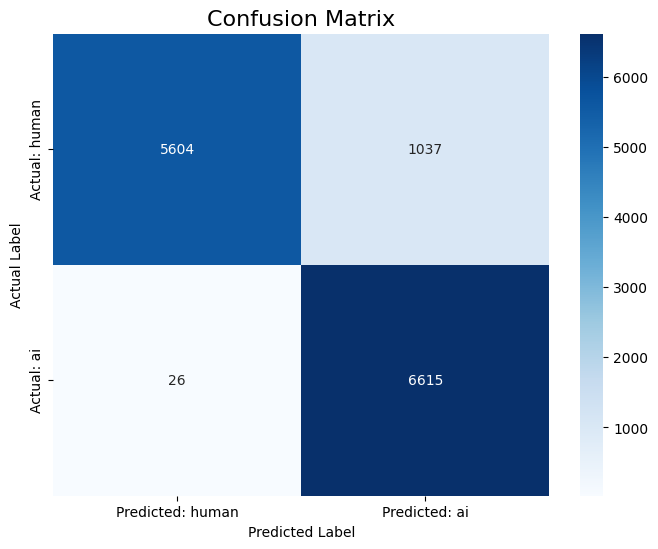

In [15]:
# %%
# =================================================================================
# 8. 메인 실행 블록 - 최종
# =================================================================================
if __name__ == '__main__':
    best_model_path = ""
    
    if DO_TRAINING:
        # 1. 훈련 시작 및 결과 받기
        best_model_path, results_df = run_training()

        if not results_df.empty:
            # 2. 결과 CSV 파일로 저장
            output_csv_path = f"{checkpoint_dir}_results.csv"
            results_df.to_csv(output_csv_path, index=False, float_format="%.4f")
            print(f"\n✅ Training history saved to '{output_csv_path}'")
            
            # 3. 결과 시각화 (표 + 그래프)
            print("\n" + "="*50); print("              종합 훈련 결과 요약"); print("="*50)
            display(results_df.style.format("{:.4f}"))
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
            
            # Loss 그래프
            ax1.plot(results_df["Epoch"], results_df["Train Loss"], marker='o', label="Train Loss")
            ax1.plot(results_df["Epoch"], results_df["Val Loss"], marker='o', label="Validation Loss")
            ax1.set_title("Model Loss per Epoch", fontsize=16)
            ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)

            # 성능 지표 그래프
            ax2.plot(results_df["Epoch"], results_df["Val F1"], marker='s', label="Validation F1")
            ax2.plot(results_df["Epoch"], results_df["Val Accuracy"], marker='x', label="Validation Accuracy")
            ax2.plot(results_df["Epoch"], results_df["Val Precision"], marker='^', label="Validation Precision")
            ax2.plot(results_df["Epoch"], results_df["Val Recall"], marker='v', label="Validation Recall")
            ax2.set_title("Model Performance per Epoch", fontsize=16)
            ax2.set_xlabel("Epoch"); ax2.set_ylabel("Score"); ax2.legend(); ax2.grid(True)
            
            plt.tight_layout()
            plt.show()
    else:
        # 훈련을 건너뛸 경우, 설정된 경로를 사용
        best_model_path = ADAPTER_PATH_FOR_INFERENCE

    # 4. 최고 성능 모델로 추론 및 최종 평가 실행
    if best_model_path and os.path.exists(best_model_path):
        run_inference(best_model_path)
        run_final_evaluation(submission_file, test_csv)
    else:
        print("Error: No valid model adapter path found for inference.")